In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
df = pd.read_csv("calloff_hub.csv")
#  data pre-observation on top 20 frquency items, ignore hub difference
top_list =  np.array(df['ITEM_NUM'].value_counts()[:20].index).tolist()

top_20 = df[df["ITEM_NUM"].isin(top_list)].drop(columns=["CUST_PLANT"]).reset_index().drop(columns=["index"])
top_20["TRX_DATE"] = top_20["TRX_DATE"].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d'))

top_20.head(2)

,ITEM_NUM,TRX_DATE,QUANTITY
0,12-12A/Y2ST3D-C30/2C(FTK),2015-07-03,4000
1,12-12A/Y2ST3D-C30/2C(FTK),2015-07-06,4000


In [3]:
pivot = top_20.pivot_table("QUANTITY", index = "TRX_DATE", columns = "ITEM_NUM")

minmax_table = top_20.groupby('ITEM_NUM')['TRX_DATE'].agg(['min','max'])
start_date = minmax_table["min"].min()
end_date = minmax_table["max"].max()

# get time series list, from first to least data  
date_list = pd.date_range(start_date, end_date, freq = "D")

In [4]:
df = pd.DataFrame( columns = top_list, index = date_list )
df.update(pivot)
#ts_format.fillna(0)

df.insert(loc=0, column='Date', value = df.index)
df.head(2)

,Date,AON7410L,AON6520,AO4407AL,AO6402AL,AO3413L_101,AO3401AL_101,AO4435L,AON7506,TC7SZ08FU,...,AON7403L,TPCC8065-H,TPCC8067-H,SSM3J327R,TPCC8131,AOZ8902CIL,RN2303,SSM3K329R,TPCC8103,12-12A/Y2ST3D-C30/2C(FTK)
2015-04-01,2015-04-01,5000,105000,27000,NaN,NaN,288000,60000,NaN,NaN,...,NaN,NaN,NaN,12000,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-02,2015-04-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60000,NaN,NaN


In [5]:
#df['week_firstday'] = df['Date'] - pd.to_timedelta(arg=df['Date'].dt.weekday, unit='D')
df.insert(loc=1, column='week_firstday', value = df['Date'] - pd.to_timedelta(arg=df['Date'].dt.weekday, unit='D'))
#df.insert(loc=1, column='week', value = dt.df["Date"].isocalendar()[1])
#df["week"] = datetime.df["Date"].isocalendar()[1]

df.head(2)

,Date,week_firstday,AON7410L,AON6520,AO4407AL,AO6402AL,AO3413L_101,AO3401AL_101,AO4435L,AON7506,...,AON7403L,TPCC8065-H,TPCC8067-H,SSM3J327R,TPCC8131,AOZ8902CIL,RN2303,SSM3K329R,TPCC8103,12-12A/Y2ST3D-C30/2C(FTK)
2015-04-01,2015-04-01,2015-03-30,5000,105000,27000,NaN,NaN,288000,60000,NaN,...,NaN,NaN,NaN,12000,NaN,NaN,NaN,NaN,NaN,NaN
2015-04-02,2015-04-02,2015-03-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60000,NaN,NaN


In [6]:
df.drop('Date', axis=1, inplace=True)
df_week = df.groupby(['week_firstday'])[df.columns.values.tolist()[1:]].agg('sum')
df_week.head(2)

,AON7410L,AON6520,AO4407AL,AO6402AL,AO3413L_101,AO3401AL_101,AO4435L,AON7506,TC7SZ08FU,AON6510,AON7403L,TPCC8065-H,TPCC8067-H,SSM3J327R,TPCC8131,AOZ8902CIL,RN2303,SSM3K329R,TPCC8103,12-12A/Y2ST3D-C30/2C(FTK)
week_firstday,,,,,,,,,,,,,,,,,,,,
2015-03-30,5000.0,105000.0,27000.0,66000.0,9000.0,288000.0,60000.0,0.0,0.0,156000.0,0.0,0.0,0.0,12000.0,0.0,0.0,0.0,60000.0,0.0,0.0
2015-04-06,45000.0,99000.0,6000.0,96000.0,108000.0,15000.0,30000.0,15000.0,9000.0,27000.0,0.0,0.0,0.0,21000.0,0.0,0.0,0.0,66000.0,0.0,0.0


In [7]:
#df_week = df_week.reset_index().drop("week_firstday",axis=1)
# after finish scaler preprocess, should reset back index with week-index

train_data = pd.DataFrame(df_week["AON7410L"])
train_data.head()

,AON7410L
week_firstday,
2015-03-30,5000.0
2015-04-06,45000.0
2015-04-13,5000.0
2015-04-20,10000.0
2015-04-27,0.0


In [8]:
# drop zero, and set mini calloff as base unit

drop_zero = train_data[train_data.AON7410L != 0]
base_unit = drop_zero.AON7410L.min()
drop_zero = drop_zero/base_unit
train_data = train_data/base_unit

(array([32., 24., 21., 16., 16.,  5.,  2.,  1.,  0.,  1.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

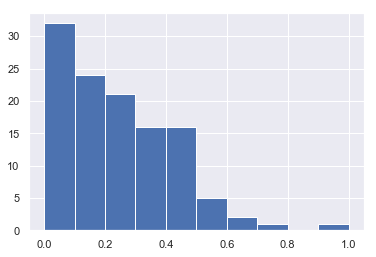

In [9]:
scaler = MinMaxScaler()
trans_minmax = scaler.fit_transform(drop_zero)
trans_minmax = pd.DataFrame(trans_minmax, columns=["AON7410L"])
plt.hist([trans_minmax.AON7410L])

In [10]:
onehot_list = list(range(int(train_data.AON7410L.max()+1)))

In [11]:
train_data = pd.DataFrame(df_week["AON7410L"])
train_data.head()

,AON7410L
week_firstday,
2015-03-30,5000.0
2015-04-06,45000.0
2015-04-13,5000.0
2015-04-20,10000.0
2015-04-27,0.0


In [12]:
base_unit = train_data[train_data.AON7410L != 0].AON7410L.min()
train_data = train_data/base_unit
onehot_list = list(range(int(train_data.AON7410L.max()+1)))
week_list = list(train_data.index.values)

In [13]:
train_data.head()

,AON7410L
week_firstday,
2015-03-30,1.0
2015-04-06,9.0
2015-04-13,1.0
2015-04-20,2.0
2015-04-27,0.0


In [14]:
df2 = pd.get_dummies(train_data["AON7410L"].astype(int))
df2.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,23,24,28,30,33,43
week_firstday,,,,,,,,,,,,,,,,,,,,,
2015-03-30,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-04-06,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2015-04-13,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-04-20,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2015-04-27,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
df_all = pd.DataFrame(0.0,index = week_list, columns = onehot_list)

In [16]:
df_all.update(df2)

In [17]:
df5 = pd.concat([train_data,df_all], axis=1)
df5.head()

,AON7410L,0,1,2,3,4,5,6,7,8,...,34,35,36,37,38,39,40,41,42,43
week_firstday,,,,,,,,,,,,,,,,,,,,,
2015-03-30,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-04-06,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-04-13,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-04-20,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-04-27,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
for i in range(df5.shape[0]):
    for j in range(df5.shape[1]):
        if int(df5.iloc[i,0])>=1:
            df5.iloc[i, 2:int(df5.iloc[i,0])+2] = 1
        elif int(df5.iloc[i,0])==0:
            df5.iloc[i,1]=1

In [19]:
df5.head()

,AON7410L,0,1,2,3,4,5,6,7,8,...,34,35,36,37,38,39,40,41,42,43
week_firstday,,,,,,,,,,,,,,,,,,,,,
2015-03-30,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-04-06,9.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-04-13,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-04-20,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2015-04-27,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
train_data = df5.drop(columns=["AON7410L"], axis=1)
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
train_data[1:6]

array([[0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 

In [21]:
window = 30
forecast_day = 12
training_data_rate = 0.95
feature = train_data.shape[1]

In [22]:
train_x = np.empty(shape=(0, window, feature))
train_y = np.empty(shape=(0, forecast_day, feature))
for i in range(len(train_data)-window-forecast_day+1):
    train_x = np.vstack((train_x, train_data[np.newaxis, i:(i+window), :]))
    #train_y = np.vstack((train_y, train_data[np.newaxis, (i+window):(i+window+forecast_day), :]))
    

In [23]:
print("X_train size: {}".format(train_x.shape))
print("y_train size: {}".format(train_y.shape))

X_train size: (95, 30, 44)
y_train size: (95, 12, 44)
